# Exercícios de Fixação de Conceitos 1 - Parte 2

### Índice
- [Definição do problema na Questão 2](#definicao_problema)
- [*Dataset*: consideraçõs e análise](#dataset_consideracoes_analise)
    - [Estrutura do *dataset*](#estrutura_dataset)
    - [Distribuição de frequências em função das classes (Histograma)](#dist_frequencias_histograma)
    - [Visualização de imagens de dígitos manuscritos](#visualizacao_imagens)
- [Conjuntos de treinamento e validação](#conjunto_treinamento_validacao)
    - [Validação cruzada](#validacao_cruzada)
    - [Dados balanceados e representativos](#dados_balanceados_representativos)
- [Questão 2 - Classificador não-linear mas linear nos parâmetros ajustáveis](#modelo_naolinear)
    - [Máquina de Aprendizado Extremo - Apresentação da arquitetura](#modelo_elm)
    - [Máquina de Aprendizado Extremo - Formulação matemática](#modelo_elm_mat)
    - [Considerações para utilizar o modelo de regressão como classificador:](#consideracoes)
    - [Parâmetros de desempenho](#param_desempenho)
- [Questão 2 - Resolução do problema](#resolucao)
    - [Especificações e construção da ELM](#build_elm)
    - [Etapa de treinamento e validação - Busca inicial](#busca_inicial)
        - [Treinamento e validação](#A1)
        - [Melhores coeficientes de regularização obtidos](#A2)
        - [Gráfico semilog do desempenho dos classificadores junto aos dados de validação considerando o erro quadrático médio](#A3)
        - [Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de classificação correta](#A4)
        - [Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de erro de classificação](#A5)
    - [Etapa de treinamento e validação - Busca refinada considerando o erro quadrático médio](#busca_refinada_MSE)
        - [Treinamento e validação](#B1)
        - [Melhor coeficiente de regularização obtido](#B2)
        - [Gráfico semilog do desempenho dos classificadores junto aos dados de validação considerando o erro quadrático médio](#B3)
    - [Etapa de treinamento e validação - Busca refinada considerando o erro de classificação](#busca_refinada_CE)
        - [Treinamento e validação](#C1)
        - [Melhor coeficiente de regularização obtido](#C2)
        - [Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de classificação correta](#C3)
        - [Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de erro de classificação](#C4)
    - [Etapa de teste](#teste)
        - [Treinamento e teste](#D1)
        - [Matriz de Confusão](#D2)
        - [Matriz de parâmetros](#D3)
        - [Gráficos de calor para os parâmetros de cada um dos 10 classificadores lineares](#D4)
        - [Exemplos de dígitos classificados incorretamente](#D5)


In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from google.colab import drive

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def onehot_to_categorical(y_onehot):
    aux = y_onehot.argmax()
    if aux < 9:
        return aux + 1
    else:
        return 0

In [0]:
def plot_hist(y_categorical, titleText, ymax, step):
    plt.figure(figsize=(8,4))
    
    plt.xlabel('Classes')
    plt.ylabel('Frequência')
    plt.xticks(range(0,10))
    plt.yticks(range(0, ymax, step))

    plt.title(titleText)
    #plt.grid(True, axis='y')

    a = plt.hist(y_categorical, range=(-0.5, 9.5), bins=20, align='left', color='royalblue');
    return a

In [0]:
def plot_digit_images(X, Y_categorical, titlesText, Nimgs=5):
    plt.figure(figsize=(15,4))
    i = rn.randint(0, X.shape[0])

    for index, (image, label) in enumerate(zip(X[i:i+Nimgs], Y_categorical[i:i+Nimgs])):
        plt.subplot(1, Nimgs, index + 1)
        X_image = np.transpose(np.reshape(image, (28, 28)))
        plt.imshow(X_image, cmap='gray')
        plt.title(titlesText + f'{label}\n', fontsize = 12)

In [5]:
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/'

data = scipy.io.loadmat(path + 'data.mat')
test = scipy.io.loadmat(path + 'test.mat')

X = data['X'] 
Y = data['S'] 

Xtest = test['Xt']
Ytest = test['St']

Y_categorical = np.array(tuple(map(onehot_to_categorical, Y)))
Ytest_categorical = np.array(tuple(map(onehot_to_categorical, Ytest)))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


-------------------------------------------------------------
<a id="definicao_problema"></a>
### Definição do problema na Questão 2

- O objetivo deste exercício consiste em sintetizar modelos não-lineares mas lineares nos parâmetros ajustáveis para classificação de padrões. É implementado um classificador baseado em Máquinas de Aprendizado Extremo (ELM).
- É utilizado o famoso *dataset* de imagens de dígitos manuscritos [MNIST](http://yann.lecun.com/exdb/mnist/), o qual contém 60.000 amostras para treinamento e 10.000 amostras para teste.
- Cada imagem de entrada contém 784 pixels (no intervalo [0, 255], correspondente a níveis de cinza), visto que a dimensão de cada uma delas é de 28x28 pixels.
- O problema de classificação investigado é do tipo multi-classe (10 classes), sendo que cada classe representa um dígito de 0 a 9.

-----------------------------------------------------------------
<a id="dataset_consideracoes_analise"></a>
### *Dataset*: Considerações e Análise

<a id="estrutura_dataset"></a>
- **Estrutura do** ***dataset*** **:**
    - Os dados de treinamento estão contidos nas matrizes $X$ e $Y$.
    
    - Matriz $X$:
        - Cada linha representa uma amostra de entrada (imagem).
        - Cada coluna contém um pixel da amostra de entrada.
        - Os valores de cada pixel foram normalizados de modo a apresentar valores no intervalo [0,1].
        - A dimensão da matriz $X$ é de 60.000x784 (Temos 60.000 amostras cada uma com 784 pixels).
        
    - Matriz $Y$:
        - Cada linha representa a saída desejada (e conhecida) para cada uma das amostras de entrada.
        - Cada saída está na representação *one-hot encoding*, isto é, só existe um elemento não nulo responsável por indicar a classe a qual a amostra pertence. Um exemplo dessa representação é dada durante a execução do código.
        - Cada coluna representa uma classe:
            - Colunas 0 a 8 representam as classes referentes aos dígitos 1 a 9, respectivamente.
            - Coluna 9 representa a classe referente ao dígito 0.
    
    - As matrizes $X_{test}$ e $Y_{test}$ do conjunto de teste possuem as mesmas características acima, mas com as seguintes dimensões:
        - A dimensão da matriz $X_{test}$ é de 10.000x784 (Temos 10.000 amostras cada uma com 784 pixels)
        - A dimensão da matriz $Y_{test}$ é de 10.000x10.

In [6]:
print(f'Dimensão da matriz X: {X.shape}')
print(f'Dimensão da matriz Y: {Y.shape}')
print('--------------------------------------')
print(f'Dimensão da matriz Xtest: {Xtest.shape}')
print(f'Dimensão da matriz Ytest: {Ytest.shape}')

Dimensão da matriz X: (60000, 784)
Dimensão da matriz Y: (60000, 10)
--------------------------------------
Dimensão da matriz Xtest: (10000, 784)
Dimensão da matriz Ytest: (10000, 10)


In [7]:
n1 = rn.randint(0, Y.shape[0])
n2 = rn.randint(0, Ytest.shape[0])

print('Exemplo do conjunto de treinamento:')
print(f'Saída na representação one-hot encoding: {Y[n1]}')
print(f'Saída na representação categórica: {Y_categorical[n1]}')

print('--------------------------------------------------------------')

print('Exemplo do conjunto de teste:')
print(f'Saída na representação one-hot encoding: {Ytest[n2]}')
print(f'Saída na representação categórica: {Ytest_categorical[n2]}')

Exemplo do conjunto de treinamento:
Saída na representação one-hot encoding: [0 0 0 0 1 0 0 0 0 0]
Saída na representação categórica: 5
--------------------------------------------------------------
Exemplo do conjunto de teste:
Saída na representação one-hot encoding: [1 0 0 0 0 0 0 0 0 0]
Saída na representação categórica: 1


<a id="dist_frequencias_histograma"></a>
- **Distribuição de frequências em função das classes (Histograma)**

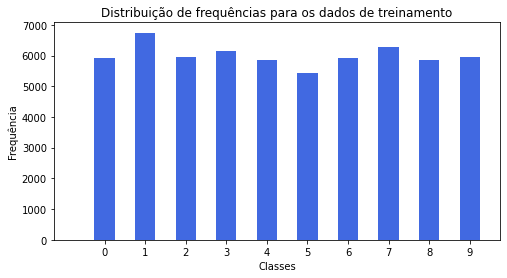

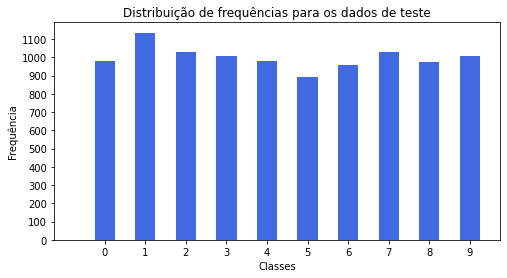

In [8]:
plot_hist(Y_categorical, titleText='Distribuição de frequências para os dados de treinamento', ymax=10000, step=1000);
plot_hist(Ytest_categorical, titleText='Distribuição de frequências para os dados de teste', ymax=1200, step=100);

<a id="visualizacao_imagens"></a>
- **Visualização de imagens de dígitos manuscritos**

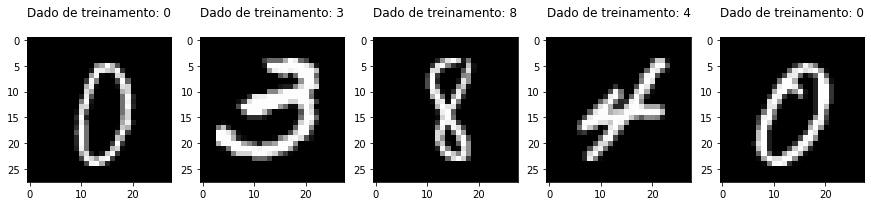

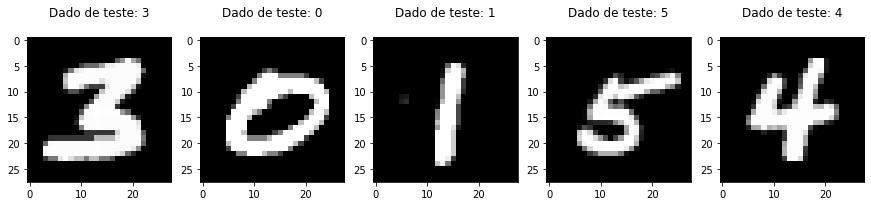

In [9]:
plot_digit_images(X, Y_categorical, titlesText='Dado de treinamento: ', Nimgs=5)
plot_digit_images(Xtest, Ytest_categorical, titlesText='Dado de teste: ', Nimgs=5)

-----------------------------------------------------------------
<a id="conjunto_treinamento_validacao"></a>
### Conjuntos de treinamento e validação

<a id="validacao_cruzada"></a>
- **Validação cruzada**
    - Para aumentar a **capacidade de generalização** do modelo, é utilizado a estratégia de validação cruzada conhecida por ***holdout***, em que dividimos as amostras de treinamento da seguinte forma:
        - Conjunto de treinamento: p% das amostras são utilizadas para treinar o modelo, de modo a produzir um classificador.
        - Conjunto de validação: (1-p)% das amostras são utilizadas para validar o modelo gerado, isto é, são utilizadas na etapa de análise de desempenho.
        - Nesta atividade, 80% das amostras de {$X$, $Y$} formam o conjunto de treinamento e 20% formam o conjunto de validação, como pode ser verificado na execução a seguir.

In [0]:
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=42)

In [11]:
print(f'Dimensão da matriz Xtrain: {Xtrain.shape}')
print(f'Dimensão da matriz Ytrain: {Ytrain.shape}')
print('--------------------------------------')
print(f'Dimensão da matriz Xval: {Xval.shape}')
print(f'Dimensão da matriz Yval: {Yval.shape}')

Dimensão da matriz Xtrain: (48000, 784)
Dimensão da matriz Ytrain: (48000, 10)
--------------------------------------
Dimensão da matriz Xval: (12000, 784)
Dimensão da matriz Yval: (12000, 10)


<a id="dados_balanceados_representativos"></a>
- **Dados balanceados e representativos**
    - Uma importante característica que devemos manter nos dois novos conjuntos é o **balanceamento entre as classes**, para que os dados utilizados tanto no conjunto de treinamento quanto no de validação sejam bastante **representativos** do problema.
    - O objetivo desta etapa é produzir modelos pouco **enviesados**.
    - Deste modo, podemos observar as distribuições de frequência dos dois conjuntos para investigar a proporção de amostras de cada uma das classes nos dois conjuntos citados.
    - Como pode ser observado nos resultados abaixo, a proporção de dados por classe em ambos os conjuntos está em um valor adequado.

In [0]:
Ytrain_categorical = np.array(tuple(map(onehot_to_categorical, Ytrain)))
Yval_categorical = np.array(tuple(map(onehot_to_categorical, Yval)))

Representação das classes no conjunto de treinamento:
Classe 0:  9.89%
Classe 1:  11.29%
Classe 2:  9.97%
Classe 3:  10.23%
Classe 4:  9.72%
Classe 5:  8.99%
Classe 6:  9.88%
Classe 7:  10.35%
Classe 8:  9.77%
Classe 9:  9.91%


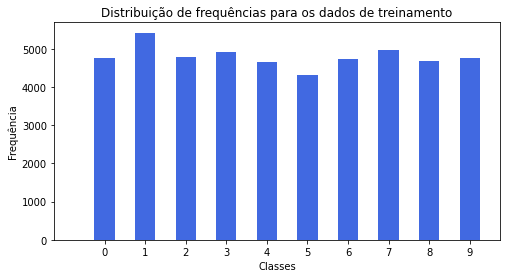

In [13]:
aux_train = plot_hist(Ytrain_categorical, titleText='Distribuição de frequências para os dados de treinamento', ymax=10000, step=1000)

aux = aux_train[0]
aux = aux[1:len(aux):2]
aux = aux*100/Xtrain.shape[0]
print('Representação das classes no conjunto de treinamento:')
for i in range(len(aux)):
    print(f'Classe {i}:  {round(aux[i],2)}%')

Representação das classes no conjunto de treinamento:
Classe 0:  9.79%
Classe 1:  11.02%
Classe 2:  9.78%
Classe 3:  10.16%
Classe 4:  9.8%
Classe 5:  9.2%
Classe 6:  9.81%
Classe 7:  10.82%
Classe 8:  9.67%
Classe 9:  9.95%


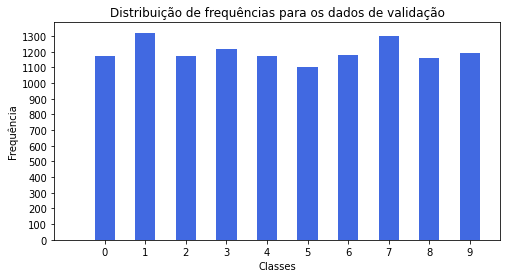

In [14]:
aux_val = plot_hist(Yval_categorical, titleText='Distribuição de frequências para os dados de validação', ymax=1500, step=100);

aux = aux_val[0]
aux = aux[1:len(aux):2]
aux = aux*100/Xval.shape[0]
print('Representação das classes no conjunto de treinamento:')
for i in range(len(aux)):
    print(f'Classe {i}:  {round(aux[i],2)}%', )

-----------------------------------------------------------------
<a id="modelo_naolinear"></a>
### Questão 2 - Classificador não-linear mas linear nos parâmetros ajustáveis

<a id="modelo_elm"></a>
- **Máquina de Aprendizado Extremo (ELM) - Apresentação da arquitetura**
    - A Figura 1 apresenta a estrutura de uma rede neural do tipo *fully-connected* com uma camada intermediária.
<img src=imagens/rede_fully-connected.PNG> </img>
    - Resumidamente, a Máquina de Aprendizado Extremo é um tipo de rede neural *fully-connected* com as seguintes características:
        - Camada de entrada: 
            - A função é passar as amostras de entrada para os neurônios da camada intermediária (não há nenhum processamento).
        - Camada intermediária: 
            - A função é realizar uma transformação não-linear nos dados de entrada.
            - Cada neurônio recebe todas as entradas (atributos), realiza uma soma ponderada delas e aplica uma função não-linear sobre o resultado dessa soma, resultando na ativação interna do neurônio.
            - **ELM: Os pesos sinápticos que ponderam as entradas são inicializados aleatoriamente e mantidos constantes, isto é, os pesos não são ajustados durante o processo de treinamento.**
            - O número de neurônios, a forma de inicialização e o tipo de função de ativação utilizada são pré-definidas.
            - Exemplos de funções de ativação: função logística, tangente hiperbólica, ReLU, Leaky-ReLU.
        - Camada de saída:
            - A função é combinam a informação produzida pela camada intermediária.
            - O número de neurônios da camada de saída deve ser compatível com a estrutura das saídas conhecidas.
            - **ELM: Os pesos sinápticos dos neurônios da camada de saída são os parâmetros ajustáveis a serem determinados.**
            - **ELM: A função de ativação dos neurônios é a função identidade. Logo, a camada de saída apenas combina linearmente os mapeamentos gerados pela camada intermediária.**
    - Observações:
        - Como a camada intermediária não participa do processo de treinamento, podemos dizer que sua função é simplesmente aplicar uma transformação não-linear nos dados de entrada, gerando "novos" dados de entrada para a camada de saída.
        - Como apenas os pesos dos neurônios da camada de saída são ajustáveis e as funções de ativação dos neurônios são funções identidade, o problema de treinamento é linear nos parâmetros ajustáveis.
        - Logo, o método de solução do para uma Máquina de Aprendizado Extremo é o mesmo utilizado na solução do modelo linear visto na Questão 1.

<a id="modelo_elm_mat"></a>

- **Máquina de Aprendizado Extremo (ELM) - Formulação matemática**
    - Considere o conjunto de amostras $ \{\textbf{x}(i), \textbf{y}(i)\}_{i=0}^{N-1}$ em que $\textbf{x} \in \mathbf{R}^K$ e $\textbf{y} \in \mathbf{R}^L$.
    - A Máquina de Aprendizado Extremo apresenta *M* neurônios na camada intermediária e *L* neurônios na camada de saída.
    - Como cada um dos neurônios da camada intermediária recebe todas as entradas de uma amostra, cada um desses neurônios é constituído por *K* pesos sinápticos **gerados aleatoriamente**.
    - Matricialmente, podemos agrupar os pesos da seguinte forma:
$$\textbf{V}=\begin{bmatrix} v_0^{(0)} & v_0^{(1)} & \ldots & v_0^{(M-1)} \\ v_1^{(0)} & v_1^{(1)} & \ldots & v_1^{(M-1)} \\ \vdots & \vdots & \ddots & \vdots \\ v_{K-1}^{(0)} & v_{K-1}^{(1)} & ... & v_{K-1}^{(M-1)} \end{bmatrix}$$
&nbsp;
        - Cada coluna da matriz $V$ contém os pesos de um neurônio.
        - Logo, a dimensão da matriz $V$ é *K x M*.
    - Empilhando todas as amostras de entrada na matriz $X$ de dimensão *N x K* e multiplicando as matrizes $X$ e $V$, obtemos a matriz de ativação interna $U_{NxM}$:
$$ U = \begin{bmatrix} u_{00} & u_{01} & \ldots & u_{0(M-1)} \\ u_{10} & u_{11} & \ldots & u_{1(M-1)} \\ \vdots & \vdots & \ddots & \vdots \\ u_{(N-1)0} & u_{(N-1)1} & ... & u_{(N-1)(M-1)} \end{bmatrix}$$
&nbsp;
        - Cada linha da matriz $U$ contém as ativações internas dos neurônios da camada intermediária para cada uma das amostras de entrada.
    - Basta, portanto, aplicar a função de ativação não-linear $f(u)$ em cada um dos elementos da matriz $U$, resultando na matriz de saída $S$ da camada intermediária:
$$ S = \begin{bmatrix} f(u_{00}) & f(u_{01}) & \ldots & f(u_{0(M-1)}) \\ f(u_{10}) & f(u_{11}) & \ldots & f(u_{1(M-1)}) \\ \vdots & \vdots & \ddots & \vdots \\ f(u_{(N-1)0}) & f(u_{(N-1)1}) & ... & f(u_{(N-1)(M-1)}) \end{bmatrix}$$
&nbsp;
    - A partir deste ponto, a construção do problema de otimização é a mesma que a realizada para o modelo de classificação linear, com as seguintes observações:
        - A matriz $\Phi$ é construída a partir da matriz de saída $S$ da camada intermediária.
$$ \Phi = \begin{bmatrix} 1 & f(u_{00}) & \ldots & f(u_{0(M-1)}) \\ 1 & f(u_{10}) & \ldots & f(u_{1(M-1)}) \\ \vdots & \vdots & \ddots & \vdots \\ 1 & f(u_{(N-1)0}) & ... & f(u_{(N-1)(M-1)}) \end{bmatrix}$$
&nbsp;
        - A matriz $W$ de parâmetros ajustáveis contém os pesos sinápticos dos *L* neurônios da camada de saída da ELM.
$$ W = \begin{bmatrix} w_0^{(0)} & w_0^{(1)} & \ldots & w_0^{(L-1)} \\ w_1^{(0)} & w_1^{(1)} & \ldots & w_1^{(L-1)} \\ \vdots & \vdots & \ddots & \vdots \\ w_M^{(0)} & w_M^{(1)} & ... & w_M^{(L-1)} \end{bmatrix}$$

<a id="consideracoes"></a>
- **Considerações para utilizar o modelo de regressão como classificador:**
    - Cada coluna das matrizes $Y$ e $\hat{Y}$ corresponde a uma classe.
    - Cada coluna de $W$ corresponde a um classificador, de modo que cada um deles é responsável por produzir uma saída referente a uma das classes do problema.
    - Novamente, as saídas desejadas de cada amostra (linhas de $Y$) estão na representação *one-hot encoding*.
    - As saídas estimadas de cada amostra (linhas de $\hat{Y}$) são números reais.
    - Para definir a classe estimada pelo classificador linear a partir dos números reais gerados na saída, consideraremos que a classe estimada é aquela associada ao maior valor produzido.

In [0]:
class LinearClassifier():
    
    def __init__(self, Xtrain, Ytrain, Xpred, Ypred):
        self.Xt = Xtrain
        self.Yt = Ytrain
        self.Xp = Xpred
        self.Yp = Ypred
        self.St = Xtrain
        self.Sp = Ypred
        [self.Nt, self.K] = Xtrain.shape
        self.m = self.K
        self.Np = Xpred.shape[0]
        self.W = None
        self.Im = None
        self.Phi_t = None
        self.Phi_p = None
        self.Yest = None  # saídas estimadas na predição
        self.Yest_onehot = None  # saídas estimadas na predição dadas na representação one-hot encoding
    
    def fit(self, coefReg):
        self.Im = np.insert(np.insert(np.eye(self.m), 0, np.zeros([1, self.m]), axis=0), 0, np.zeros([1, self.m+1]), axis=1)
        self.Phi_t = np.insert(self.St, 0, np.ones([1, self.Nt]), axis=1)
        
        self.W = np.linalg.inv(np.transpose(self.Phi_t).dot(self.Phi_t) + coefReg*self.Im).dot(np.transpose(self.Phi_t).dot(self.Yt))
    
    def predict(self):
        self.Phi_p = np.insert(self.Sp, 0, np.ones([1, self.Np]), axis=1)
        
        self.Yest = self.Phi_p.dot(self.W)
        LinearClassifier.onehotencoding(self)
        
    def onehotencoding(self):
        # Cria uma matriz de saídas estimadas na representação one-hot encoding:
        self.Yest_onehot = self.Yest.copy()
        for i in range(0, self.Yest_onehot.shape[0]):   
            np.place(self.Yest_onehot[i], self.Yest_onehot[i] < np.max(self.Yest_onehot[i]), 0)
            np.place(self.Yest_onehot[i], self.Yest_onehot[i] == np.max(self.Yest_onehot[i]), 1)


In [0]:
class ELM(LinearClassifier):
    
    def __init__(self, Xtrain, Ytrain, Xpred, Ypred, m):
        super().__init__(Xtrain, Ytrain, Xpred, Ypred)
        self.m = m
        self.V = None

    def param_intermediate_layer(self, dist, param1, param2):
        np.random.seed(42)
        if dist == 'normal':
            # param1 = média  -  param2 = desvio padrão
            self.V = np.random.normal(param1, param2, (self.K, self.m))
            self.St = self.Xt.dot(self.V)
            self.Sp = self.Xp.dot(self.V)
        elif dist == 'uniform':
            # param1 = valor inicial   -   param2 = valor final
            self.V = np.random.uniform(param1, param2, (self.K, self.m))
            self.St = self.Xt.dot(self.V)
            self.Sp = self.Xp.dot(self.V)
            
    def activ_func_intermediate_layer(self, activ_func):
        
        if activ_func == 'tanh':
            self.St = np.tanh(self.St)
            self.Sp = np.tanh(self.Sp)
        elif activ_func == 'relu':
            np.place(self.St, self.St <= 0, 0)
            np.place(self.Sp, self.Sp <= 0, 0)

<a id="param_desempenho"></a>
- **Parâmetros de desempenho**
    - Duas métricas são utilizadas para analisar o desempenho do classificador linear: erro quadrático médio e erro de classificação.
    - Erro Quadrático Médio (MSE):
$$MSE = \frac{1}{NL}\sum_{i=0}^{N-1}\sum_{k=0}^{L-1}[y_k(i)-\hat{y}_k(i)]^2$$
    - Taxa de Erro de Classificação (CE):
$$ CE = \frac{N_{erro}}{N} $$
&nbsp;

    onde $N_{erro}$ indica o número de amostras classificadas incorretamente.    

In [0]:
class Metrics():
    
    def __init__(self, Y, Yest, Yest_onehot):
        self.Y = Y
        self.Yest = Yest
        self.Yest_onehot = Yest_onehot    
        self.MSE = None
        self.CE = None
    
    def meansquared_error(self):
        e = (self.Y - self.Yest)**2
        self.MSE = np.sum(np.sum(e, axis=1), axis=0) # / (N*L), onde [N, L] = self.Yval.shape
        return self.MSE
    
    def classification_error(self):
        matches = []
        
        for i in range(0, self.Y.shape[0]):
            matches.append(np.array_equal(self.Y[i], self.Yest_onehot[i]))
        
        score = matches.count(True)
        err = self.Y.shape[0] - score
        self.CE = err/(err + score)
        return self.CE

-----------------------------------------------------------------
<a id="resolucao"></a>
### Questão 2 - Resolução do problema

<a id="build_elm"> </a>
- **Especificações e construção da ELM**
    - Conforme espeficificado no texto da Questão 2, a ELM tem as seguintes especificações obrigatórias:
        - 500 neurônios na camada intermediária (*M = 500*).
        - Os pesos sinápticos dos neurônios da camada intermediária são gerados aleatoriamente de acordo com uma distribuição gaussiana de média zero e desvio padrão igual a 0.2.
        - Os pesos são gerados uma única vez durante a instanciação na classe ELM, de modo que a mesma matriz de pesos da camada intermediária é utilizada em todas as etapas da resolução.
    - A escolha da função de ativação dos neurônios foi deixada em aberto. Nessa etapa, foi escolhido a função tangente hiperbólica.  

In [0]:
# instancia da classe ELM utilizado nas etapas de treinamento e validação:
classifier = ELM(Xtrain, Ytrain, Xval, Yval, m=500)
classifier.param_intermediate_layer(dist='normal', param1=0, param2=0.2)
classifier.activ_func_intermediate_layer(activ_func='tanh')

- Inicialmente será feito uma busca pelos coeficientes de regularização $\lambda$, entre os valores abaixo, que levem aos menores valores de erro quadrático médio e taxa de erro de classificação. 
$$ A = \{2^{-20},\; 2^{-19}, \ldots,\; 2^{0},\; \ldots, \; 2^{+19},\ldots,\; 2^{+20} \}$$
&nbsp;
    - Para cada $\lambda$ do conjunto $A$:
        - Treinar o modelo (obter a matriz $W$) com os dados de treinamento.
        - Estimar as saídas $\hat{Y}$ para os dados de validação.
        - Calcular e armazenar o erro quadrático médio e o erro de classificação para os dados de validação.
    - Os resultados são reportados por meio de gráficos semilog do desempenho dos classificadores junto aos dados de validação.
&nbsp;


- Em seguida, será feita uma busca refinada entorno dos dois coeficientes de regularização obtidos anteriormente.
    - Implementar o mesmo algoritmo acima.
&nbsp;


- Para o coeficiente de regularização que levou ao melhor desempenho associado ao erro de classificação:
    - Treinar o modelo com todos os dados de treinamento (conjunto de 60.000 amostras)
    - Estimar as saídas $\hat{Y}$ para os dados de treinamento.
    - Resultados:
        - Obter a matriz de parâmetros $W$.
        - Matriz de confusão do classificador quando aplicado aos dados de treinamento.
        - Exemplos de dados de treinamento classificados incorretamente.

<a id="busca_inicial"> </a>
- **Etapa de treinamento e validação - Busca inicial pelos melhores coeficientes de regularização:**

<a id="A1"> </a>
- Treinamento e validação:

In [0]:
coefs = [2**n for n in range(-20, 21, 1)]

ms_errors = np.array([]) # Armazena os valores de erros quadráticos médios
ce_errors = np.array([]) # Armazena os valores de erros de classificação
best_coefs_MSE = []
best_coefs_CE = []

for coef in coefs:
    classifier.fit(coef) # treinamento
    classifier.predict() # validação
    
    desempenho = Metrics(Yval, classifier.Yest, classifier.Yest_onehot)
    
    ms_errors = np.append(ms_errors, desempenho.meansquared_error())
    ce_errors = np.append(ce_errors, desempenho.classification_error())

best_coefs_MSE.append(coefs[np.argmin(ms_errors)])  # melhor coef. de regularização considerando o erro quadrático médio
best_coefs_CE.append(coefs[np.argmin(ce_errors)])  # melhor coef. de regularização considerando o erro de classificação

<a id="A2"> </a>
- Melhores coeficientes de regularização obtidos:

In [20]:
ms_errors1 = ms_errors.copy()
ce_errors1 = ce_errors.copy()
print(f'Coeficiente de regularização para o menor erro quadrático médio: {best_coefs_MSE}')
print(f'Coeficiente de regularização para o menor erro de classificação: {best_coefs_CE}')

Coeficiente de regularização para o menor erro quadrático médio: [128]
Coeficiente de regularização para o menor erro de classificação: [64]


<a id="A3"> </a>
- Gráfico semilog do desempenho dos classificadores junto aos dados de validação considerando o erro quadrático médio:

Text(0, 0.5, 'Erro Quadrático Médio')

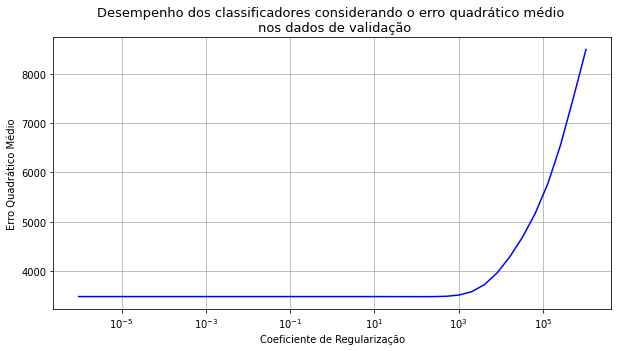

In [21]:
plt.figure(figsize=(10,5))
plt.semilogx(coefs, ms_errors1, color='b')
plt.grid(True, which="both")
plt.xticks()
plt.title('Desempenho dos classificadores considerando o erro quadrático médio \n nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Erro Quadrático Médio')
# plt.show()

#plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Imagens_Q2/desempenho_mse_busca_inicial.png')

<a id="A4"> </a>
- Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de classificação correta:

Text(0, 0.5, 'Taxa de classificação correta')

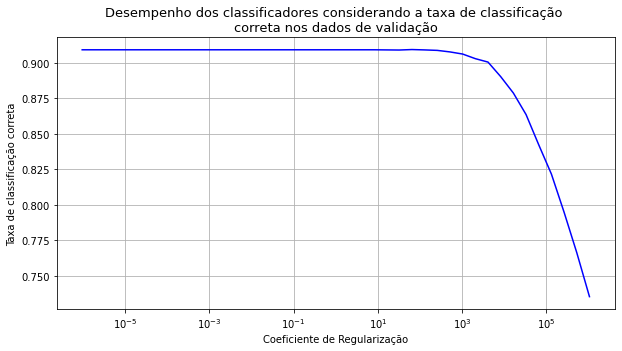

In [22]:
plt.figure(figsize=(10,5))
plt.semilogx(coefs, [1-erro for erro in ce_errors1], color='b')
plt.grid(True, which="both")
plt.title('Desempenho dos classificadores considerando a taxa de classificação \ncorreta nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Taxa de classificação correta')
#plt.show()

#plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Imagens_Q2/desempenho_taxaacerto_busca_inicial.png')

<a id="A5"> </a>
- Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de erro de classificação:

Text(0, 0.5, 'Taxa de erro de classificação')

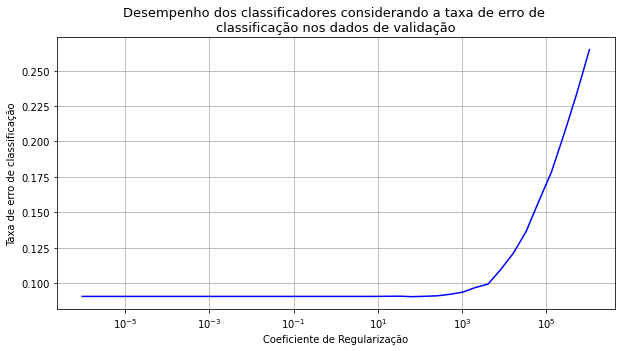

In [23]:
plt.figure(figsize=(10,5))
plt.semilogx(coefs, ce_errors1, color='b')
plt.grid(True, which="both")
plt.title('Desempenho dos classificadores considerando a taxa de erro de \nclassificação nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Taxa de erro de classificação')
#plt.show()

#plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Imagens_Q2/desempenho_taxaerro_busca_inicial.png')

<a id="busca_refinada_MSE"> </a>
- **Etapa de treinamento e validação - Busca refinada pelo melhor coeficiente de regularização considerando o erro quadrático médio**

<a id="B1"> </a>
- Busca refinada I: Treinamento e validação do modelo para 100 valores de $\lambda$ no intervalo $[78, 178]$ linearmente espaçados

- Busca refinada II: Treinamento e validação do modelo para 100 valores de $\lambda$ no intervalo $[136.63, 146.63]$ linearmente espaçados 


In [0]:
coefs = np.linspace(best_coefs_MSE[1]-5, best_coefs_MSE[1]+5, num=100)

ms_errors = np.array([]) # Armazena os valores de erros quadráticos médios

for coef in coefs:
    classifier.fit(coef) # treinamento
    classifier.predict() # validação
    
    desempenho = Metrics(Yval, classifier.Yest, classifier.Yest_onehot)
    ms_errors = np.append(ms_errors, desempenho.meansquared_error())
    
best_coefs_MSE.append(coefs[np.argmin(ms_errors)])

<a id="B2"> </a>
- Melhor coeficiente de regularização obtido:

In [52]:
ms_errors2 = ms_errors.copy()

print(f'Coeficiente de regularização para o menor erro quadrático médio: {best_coefs_MSE}')
print(f'Coeficiente de regularização para o menor erro de classificação: {best_coefs_CE}')

#np.savetxt('/content/gdrive/My Drive/Colab Notebooks/Imagens_Q2/best_coefs_MSE.txt', best_coefs_MSE, fmt='%.5f')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/Imagens_Q2/best_coefs_CE.txt', best_coefs_CE, fmt='%.5f')

Coeficiente de regularização para o menor erro quadrático médio: [128, 141.63636363636363, 141.68686868686868]
Coeficiente de regularização para o menor erro de classificação: [64, 61.47474747474748, 68.04040404040404, 68.08080808080808]


<a id="B3"> </a>
- Gráfico semilog do desempenho dos classificadores junto aos dados de validação considerando o erro quadrático médio:

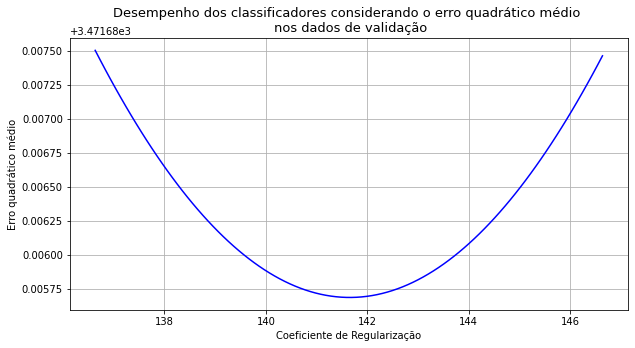

In [33]:
plt.figure(figsize=(10,5))
plt.plot(coefs, ms_errors2, color='b')
plt.grid(True, which="both")
plt.title('Desempenho dos classificadores considerando o erro quadrático médio \n nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Erro quadrático médio')
#plt.show()

plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Imagens_Q2/desempenho_mse_busca_refinada2.png')

<a id="busca_refinada_CE"> </a>
- **Etapa de treinamento e validação - Busca refinada pelo melhor coeficiente de regularização considerando o erro de classificação**

<a id="C1"> </a>
- Busca refinada I: Treinamento e validação do modelo para 100 valores de $\lambda$ no intervalo $[14, 114]$ espaçados linearmente
- Busca refinada II: Treinamento e validação do modelo para 100 valores de $\lambda$ no intervalo $[60, 80]$ espaçados linearmente 

In [0]:
coefs = np.linspace(60, 80, num=100)

ce_errors = [] # Armazena os valores de erros de classificação

for coef in coefs:
    classifier.fit(coef) # treinamento
    classifier.predict() # validação
    
    desempenho = Metrics(Yval, classifier.Yest, classifier.Yest_onehot)
    ce_errors.append(desempenho.classification_error())

best_coefs_CE.append(coefs[np.argmin(ce_errors)])

<a id="C2"> </a>
- Melhor coeficiente de regularização obtido:

In [50]:
ce_errors2 = ce_errors.copy()

print(f'Coeficiente de regularização para o menor erro quadrático médio: {best_coefs_MSE}')
print(f'Coeficiente de regularização para o menor erro de classificação: {best_coefs_CE}')

Coeficiente de regularização para o menor erro quadrático médio: [128, 141.63636363636363, 141.68686868686868]
Coeficiente de regularização para o menor erro de classificação: [64, 61.47474747474748, 68.04040404040404, 68.08080808080808]


<a id="C3"> </a>
- Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de classificação correta:

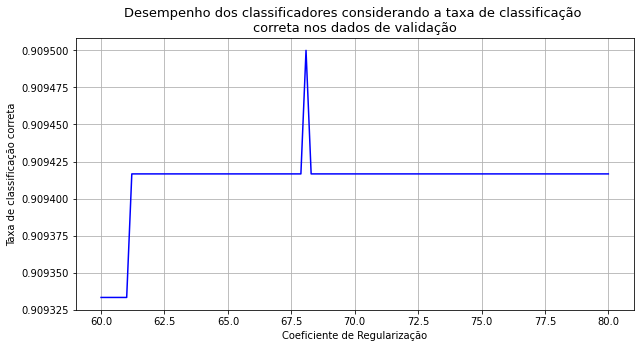

In [55]:
plt.figure(figsize=(10,5))
plt.plot(coefs, [1-erro for erro in ce_errors2], color='b')
plt.grid(True, which="both")
plt.title('Desempenho dos classificadores considerando a taxa de classificação \ncorreta nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Taxa de classificação correta')
#plt.show()

plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Imagens_Q2/desempenho_taxaacerto_busca_refinada.png')

<a id="C4"> </a>
- Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de erro de classificação:

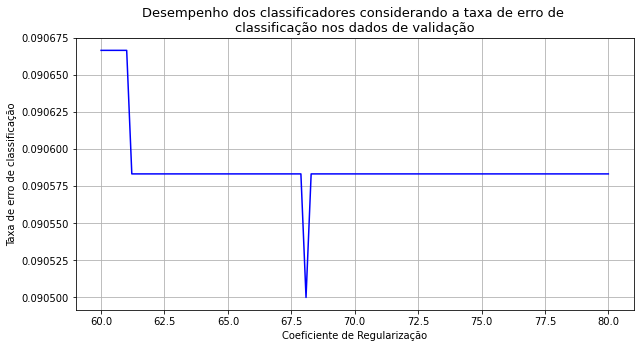

In [56]:
plt.figure(figsize=(10,5))
plt.plot(coefs, ce_errors2, color='b')
plt.grid(True, which="both")
plt.title('Desempenho dos classificadores considerando a taxa de erro de \nclassificação nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Taxa de erro de classificação')
#plt.show()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Imagens_Q2/desempenho_taxaerro_busca_refinada2.png')

In [57]:
best_coefs = np.array([best_coefs_MSE, best_coefs_CE])
print(best_coefs)
print(best_coefs.shape)

# np.savetxt('melhores_coeficientes.txt', best_coefs, fmt='%.5f')

[list([128, 141.63636363636363, 141.68686868686868])
 list([64, 61.47474747474748, 68.04040404040404, 68.08080808080808])]
(2,)


<a id="teste"> </a>
- **Etapa de teste**

In [0]:
# instancia da classe ELM utilizado nas etapas de treinamento e teste do modelo final:
bestClassifier = ELM(X, Y, Xtest, Ytest, m=500)
bestClassifier.param_intermediate_layer(dist='normal', param1=0, param2=0.2)
bestClassifier.activ_func_intermediate_layer(activ_func='tanh')

In [61]:
V1 = classifier.V
V2 = bestClassifier.V
print(V1[0:10, 0])
print(V2[0:10, 0])

[ 0.09934283  0.18523551  0.27987109  0.15567222 -0.13503565  0.1141226
 -0.38156151  0.23612818 -0.17269872 -0.19175569]
[ 0.09934283  0.18523551  0.27987109  0.15567222 -0.13503565  0.1141226
 -0.38156151  0.23612818 -0.17269872 -0.19175569]


<a id="D1"> </a>
- Treinamento do modelo com os 60.000 dados de treinamento e predição com os 10.000 dados de teste

In [0]:
coef = best_coefs_CE[-1]

bestClassifier.fit(coef) #treinamento
bestClassifier.predict()

desempenho = Metrics(Ytest, bestClassifier.Yest, bestClassifier.Yest_onehot)

ms_error = desempenho.meansquared_error()
ce_error = desempenho.classification_error()

In [70]:
metricas = np.array([coef, ms_error, ce_error])
print(metricas)
# np.savetxt('metricas_classificador_final.txt', metricas, fmt='%.5f')

[6.80808081e+01 2.79856610e+03 8.48000000e-02]


<a id="D2"> </a>
- Matriz de Confusão

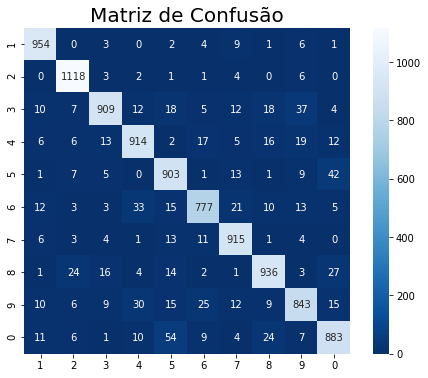

In [71]:
Ytest_categorical = np.array(tuple(map(onehot_to_categorical, Ytest)))
Yest_categorical = np.array(tuple(map(onehot_to_categorical, bestClassifier.Yest_onehot)))

index = [i for i in "1234567890"]

plt.figure(figsize=(8, 6))
plt.title('Matriz de Confusão', fontsize=20)
plt.xlabel('Classes Verdadeiras')
plt.ylabel('Classes Estimadas')
sns.heatmap(confusion_matrix(Ytest_categorical, Yest_categorical), annot=True, annot_kws={'size': 10}, square=True, fmt='d', xticklabels=index, yticklabels=index, cmap='Blues_r');

#plt.savefig('matriz_de_confusao.png')

<a id="D3"> </a>
- Matriz de parâmetros do modelo:

In [0]:
W = best_classifier.W
print(W.shape)

#np.savetxt('matriz_parametros_W.txt', W, fmt='%.10f')

<a id="D4"> </a>
- Gráficos de calor para os parâmetros de cada um dos 10 classificadores lineares:

In [0]:
Wk = np.transpose(np.delete(W, 0, axis=0))
Yk = list(range(1, 10))
Yk.append(0)

print(Wk.shape)
print(Yk)

In [0]:
plt.figure(figsize=(25, 10))

for index, (w_vec, label) in enumerate(zip(Wk[0:10], Yk[0:10])):
    plt.subplot(2, 5, index + 1)
    W_image = np.transpose(np.reshape(w_vec, (28, 28)))
    sns.heatmap(W_image)
    plt.title('Classe: ' + f'{label}\n', fontsize = 12)

#plt.savefig('mapas_de_calor.png')

<a id="D5"> </a>
- Exemplos de dígitos classificados incorretamente: 

In [0]:
estErr = np.array([1 if imagem != 0 else 0 for imagem in Ytest_categorical-Yest_categorical])
indices = list(np.where(estErr == 1)[0])

plt.figure(figsize=(15,8))

N = 50

for index_subplot, index_amostra in enumerate(indices[N:N+10]):
    # print(index_subplot, index_amostra)
    plt.subplot(2, 5, index_subplot+1)
    X_image = np.transpose(np.reshape(Xtest[index_amostra], (28, 28)))
    plt.imshow(X_image, cmap='gray')
    plt.title(f'Classe verdadeira: {Ytest_categorical[index_amostra]}\n Classe estimada: {Yest_categorical[index_amostra]}\n')
    
#plt.savefig('digitos_classificados_incorretamente.png')